# Reading the corpus 

In [1]:
import rarfile
import re

corpus = []

with rarfile.RarFile("./data/corpus.rar") as rar_corpus:
    for file in rar_corpus.infolist():
        if file.is_file():
            with rar_corpus.open(file) as doc:
                doc_class, doc_name = re.search(
                    r"training\/(.*)\/(.*)", file.filename
                ).groups()
                doc_content = doc.read().decode("utf-8")
                corpus.append((doc_class, doc_content))

# Building the dataset

In [4]:
from sklearn.model_selection import train_test_split

docs = [doc for _, doc in corpus]
classes = [cls for cls, _ in corpus]

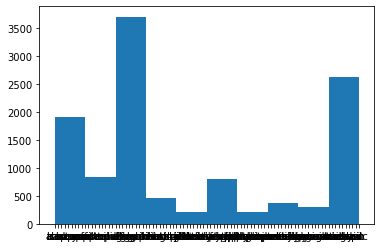

In [16]:
import matplotlib.pyplot as plt

plt.hist(classes)
plt.show()

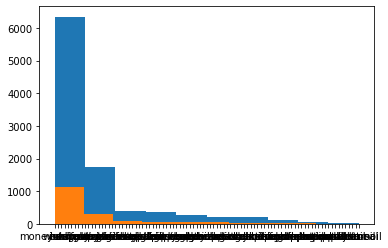

In [32]:
train_docs, test_docs, train_classes, test_classes = train_test_split(
    docs, classes, test_size=0.15, random_state=10
)

plt.hist(train_classes)
plt.hist(test_classes)
plt.show()

# Feature extraction and selection from corpus

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/obadakhalili/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [109]:
def tokenize_normalize(
    doc,
    tokenize=word_tokenize,
    stem=PorterStemmer().stem,
    stopwords=stopwords.words("english"),
):
    return [
        stem(token)
        for token in tokenize(doc)
        if len(token) > 1 and token not in stopwords
    ]


feature_extraction_steps = [
    TfidfVectorizer(
        tokenizer=tokenize_normalize,
        sublinear_tf=True,  # Computes the logarithm of the term frequency
    ),
    TruncatedSVD(random_state=0),
]

# Training

In [138]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics

## Random Forest

In [83]:
randomforest_gscv = GridSearchCV(
    make_pipeline(
        *feature_extraction_steps,
        RandomForestClassifier(random_state=0, n_estimators=400),
    ),
    param_grid={
        "truncatedsvd__n_components": [20, 50],
    },
    # f1 score for multiclass classification where precision/recall are computed for each class then weight-averaged into one score
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
)
randomforest_gscv.fit(train_docs, train_classes)

print(
    f"Best parameter(s): {randomforest_gscv.best_params_}, with score {randomforest_gscv.best_score_}"
)

/home/obadakhalili/dev/NLP/text-classification/.venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best parameter(s): {'truncatedsvd__n_components': 50}, with score 0.6582195251427237


In [102]:
def print_classification_metrics(classifier):
    for metric in [
        metrics.precision_score,
        metrics.recall_score,
        metrics.f1_score,
        metrics.accuracy_score,
    ]:
        score = (
            metric(test_classes, classifier.predict(test_docs))
            if metric == metrics.accuracy_score
            else metric(
                test_classes,
                classifier.predict(test_docs),
                average="weighted",
                zero_division=1,
            )
        )
        print(f"{metric.__name__}: {score}")

In [105]:
randomforest_classifier = randomforest_gscv.best_estimator_
print_classification_metrics(randomforest_classifier)

precision_score: 0.674422838074636
recall_score: 0.6664719626168224
f1_score: 0.6558170979174152
accuracy_score: 0.6664719626168224


## Gradient Boosted Trees

In [116]:
gbt_gscv = GridSearchCV(
    make_pipeline(
        *feature_extraction_steps, GradientBoostingClassifier(random_state=0)
    ),
    param_grid={
        # We already know that 50 components is the best option from our previous experiment with Random Forest
        "truncatedsvd__n_components": [50],
        "gradientboostingclassifier__n_estimators": [100, 400],
    },
    scoring="f1_weighted",
    cv=2,
    n_jobs=-1,
)
gbt_gscv.fit(train_docs, train_classes)

print(f"Best parameter(s): {gbt_gscv.best_params_}, with score {gbt_gscv.best_score_}")

/home/obadakhalili/dev/NLP/text-classification/.venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Best parameter(s): {'gradientboostingclassifier__n_estimators': 100, 'truncatedsvd__n_components': 50}, with score 0.6120292714712305


In [117]:
gbt_classifier = gbt_gscv.best_estimator_
print_classification_metrics(gbt_classifier)

precision_score: 0.6308613831435813
recall_score: 0.6238317757009346
f1_score: 0.6138354555748186
accuracy_score: 0.6238317757009346


## SVM

In [149]:
svm_gscv = GridSearchCV(
    make_pipeline(*feature_extraction_steps, LinearSVC(random_state=0)),
    param_grid={
        "truncatedsvd__n_components": [50],
        "linearsvc__C": [1, 10],
    },
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
)
svm_gscv.fit(train_docs, train_classes)

print(f"Best parameter(s): {svm_gscv.best_params_}, with score {svm_gscv.best_score_}")

/home/obadakhalili/dev/NLP/text-classification/.venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameter(s): {'linearsvc__C': 10, 'truncatedsvd__n_components': 50}, with score 0.6951564304650335


In [150]:
svm_classifier = svm_gscv.best_estimator_
print_classification_metrics(svm_classifier)

precision_score: 0.7430014456623284
recall_score: 0.731892523364486
f1_score: 0.7050519183509971
accuracy_score: 0.731892523364486
